## Models, Models, Models!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from this post I look up every time: https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

#from extra extras
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
#from OH with Ben
import pickle

### Train/Validation Split

In [2]:
#read in chosen clean data set and specify which columns to regress on
data = pd.read_csv('../data/cleaned_train.csv')

#open the results from the file
#https://stackoverflow.com/questions/57022703/pickle-encoding-utf-8-issue
#https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict-or-any-other-python-object/33245595#33245595
with open('../data/results.pickle', 'rb') as read_file:
    results = pickle.load(read_file)
    

In [3]:
#the most basic sets of columns
v1_cols = ['garage_area', 
                 'total_bsmt_sf', 
                 'bsmt_full_bath', 
                 'full_bath', 
                 'bsmt_half_bath', 
                 'half_bath',
                 'overall_qual', 
                 'gr_liv_area', 
                 'year_built', 
                 'year_remod/add'
]

#my first set of engineered columns, missing signal from baths
first_engineer_cols = ['overall_qual', 
                    'total_overall_sf', 
                    'garage_interact',
                    'years_interact',
                    'exter_qual_ord',
                    'bsmt_qual_ord',
                    'kitchen_qual_ord',
                    'lot_config', 
                    'neighborhood'
]

#the set of engineered columns used for my baseline model
second_engineer_cols = ['overall_qual', 
                    'total_overall_sf', 
                    'garage_interact',
                    'years_interact',
                    'total_full_bath',
                    'sf_bath',
                    'exter_qual_ord',
                    'bsmt_qual_ord',
                    'kitchen_qual_ord',
                    'lot_config', 
                    'neighborhood'
]

#drop sf_bath, not any better, no comment
third_engineer_cols = ['overall_qual', 
                    'total_overall_sf', 
                    'garage_interact',
                    'years_interact',
                    'total_full_bath',
                    'exter_qual_ord',
                    'bsmt_qual_ord',
                    'kitchen_qual_ord',
                    'lot_config', 
                    'neighborhood'
]

#the set of columns used for my privacy model
fourth_engineer_cols = ['overall_qual', 
                    'total_overall_sf', 
                    'garage_interact',
                    'years_interact',
                    'total_full_bath',
                    'sf_bath',
                    'fence_ord',
                    'bldg_type_ord',
                    'exter_qual_ord',
                    'bsmt_qual_ord',
                    'kitchen_qual_ord',
                    'lot_config', 
                    'neighborhood'
]


cols_of_interest = fourth_engineer_cols

In [4]:
X = data[cols_of_interest]
y = data['saleprice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=8)

### Null Model

Below is our RMSE score and percent variance to beat.

In [5]:
null_pred = y_train.mean()
null_train_rmse = mean_squared_error(y_train, np.full_like(y_train, null_pred), squared=False)
null_val_rmse = mean_squared_error(y_val, np.full_like(y_val, null_pred), squared=False)
print(f"Null Training RMSE: {round(null_train_rmse, 2)}")
print(f"Null Validation RMSE: {round(null_val_rmse, 2)}")
print(f"Null RMSE Variance: {round(((null_val_rmse - null_train_rmse)/null_train_rmse) * 100, 2)}%")

Null Training RMSE: 75279.37
Null Validation RMSE: 72518.81
Null RMSE Variance: -3.67%


### Iterative Modeling

#### Helper Functions

In [6]:
#could also use make_scorer
def rmse(estimator, X, y):
    '''
    Converts SkLearn's mean_squared_error function into one useable by cross_val_score
    Returns the Root Mean Squared Error of the given estimator's predictions on X, compared to y
    Used more frequently in previous iterations of this notebook
    '''
    return mean_squared_error(y, estimator.predict(X), squared=False)

In [7]:
def fit_pipe(model):
    '''
    Creates a Pipeline object fitted to the current global X_train and y_train
    Returns None
    '''
    
    #adapted from class code extra-extras
    if str(model) == 'LinearRegression()':
        ctx = ColumnTransformer(
            [('ss', StandardScaler(), X_train._get_numeric_data().columns),
            ('ohe', OneHotEncoder(handle_unknown = 'ignore', drop='first'), [x for x in X_train.columns if x not in X_train._get_numeric_data().columns])
            ]
        )
    else:
        ctx = ColumnTransformer(
            [('ss', StandardScaler(), X_train._get_numeric_data().columns),
            ('ohe', OneHotEncoder(handle_unknown = 'ignore'), [x for x in X_train.columns if x not in X_train._get_numeric_data().columns])
            ]
        )

            
    pipe = Pipeline([
        ('ctx', ctx),
        ('model', TransformedTargetRegressor(model, func=np.log, inverse_func=np.exp))
    ])

    #fit
    pipe.fit(X_train, y_train)

    #predict
    train_preds = pipe.predict(X_train)
    val_preds = pipe.predict(X_val)
    
    eval_pipe(pipe, train_preds, val_preds)
    

In [8]:
def eval_pipe(pipe, train_preds, val_preds):
    '''
    Prints evaluation metrics and LINE assumption plots for the given Pipeline and predicted values
    Appends the Validation RMSE, current global columns of interest, and Pipeline to the results object
    Returns None
    '''
    model_name = pipe.named_steps.model.regressor_
    
    #line assumption plots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(val_preds, (y_val - val_preds))
    ax[0].axhline(0, color='red')
    ax[0].set_xlabel("Validation Prediction")
    ax[0].set_ylabel("Residual Difference")
    
    ax[1].hist(y_val - val_preds, bins=30)
    ax[1].axvline((y_val - val_preds).mean(), color='red')
    ax[1].set_xlabel("Residuals")
    ax[1].set_ylabel("Count")
    
    plt.suptitle(f"{model_name} LINE Plots")
    plt.show()
    
    #print(cross_val_score(pipe, X_train, y_train, scoring=rmse))
    
    #evaluate
    train_rmse = mean_squared_error(y_train, train_preds, squared=False)
    val_rmse = mean_squared_error(y_val, val_preds, squared=False)
    percent_variance = ((val_rmse - train_rmse)/train_rmse) * 100
    
    print(f"{model_name} Training RMSE: {round(train_rmse, 2)}")
    print(f"{model_name} Validation RMSE: {round(val_rmse, 2)}")
    print(f"{model_name} RMSE Percent Variance: {round(percent_variance, 2)}%")
    print()
    print(f"{model_name} Training R2: {round(r2_score(y_train, train_preds), 2)}")
    print(f"{model_name} Validation R2: {round(r2_score(y_val, val_preds), 2)}")
    
    #update results
    global results
    results.append((val_rmse, cols_of_interest, pipe))
    

#### Models

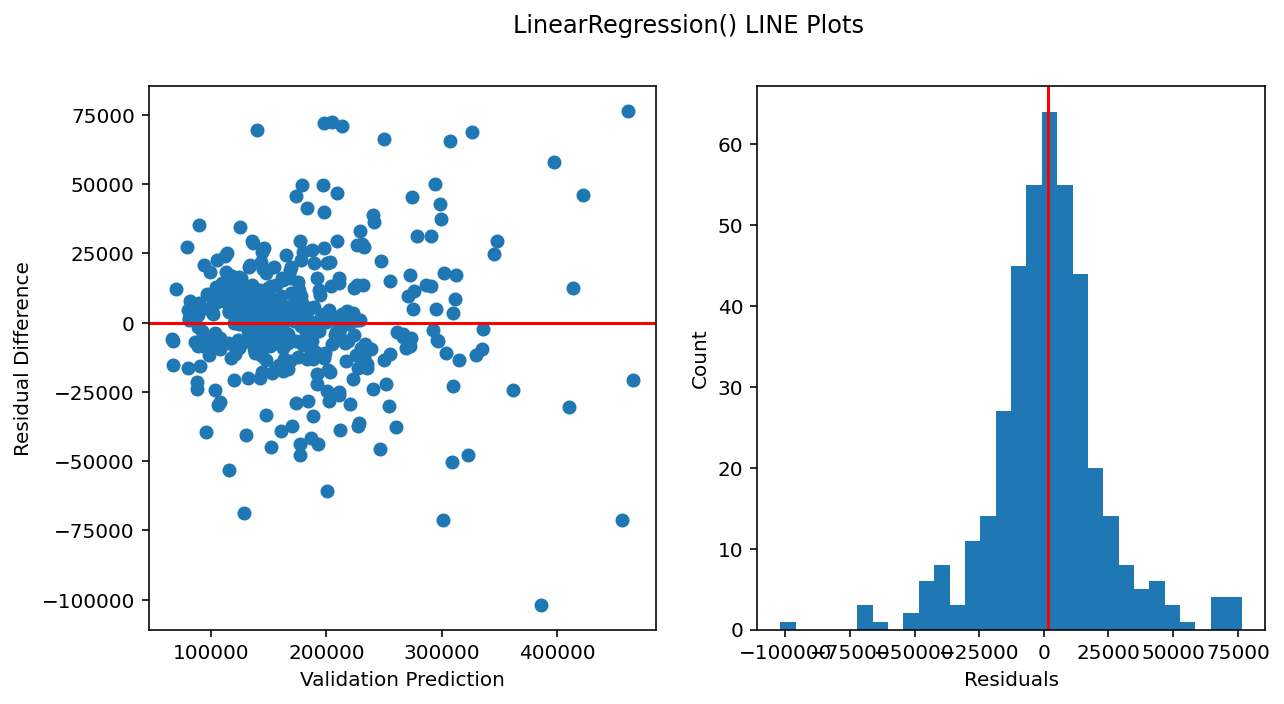

LinearRegression() Training RMSE: 22125.82
LinearRegression() Validation RMSE: 22050.78
LinearRegression() RMSE Percent Variance: -0.34%

LinearRegression() Training R2: 0.91
LinearRegression() Validation R2: 0.91


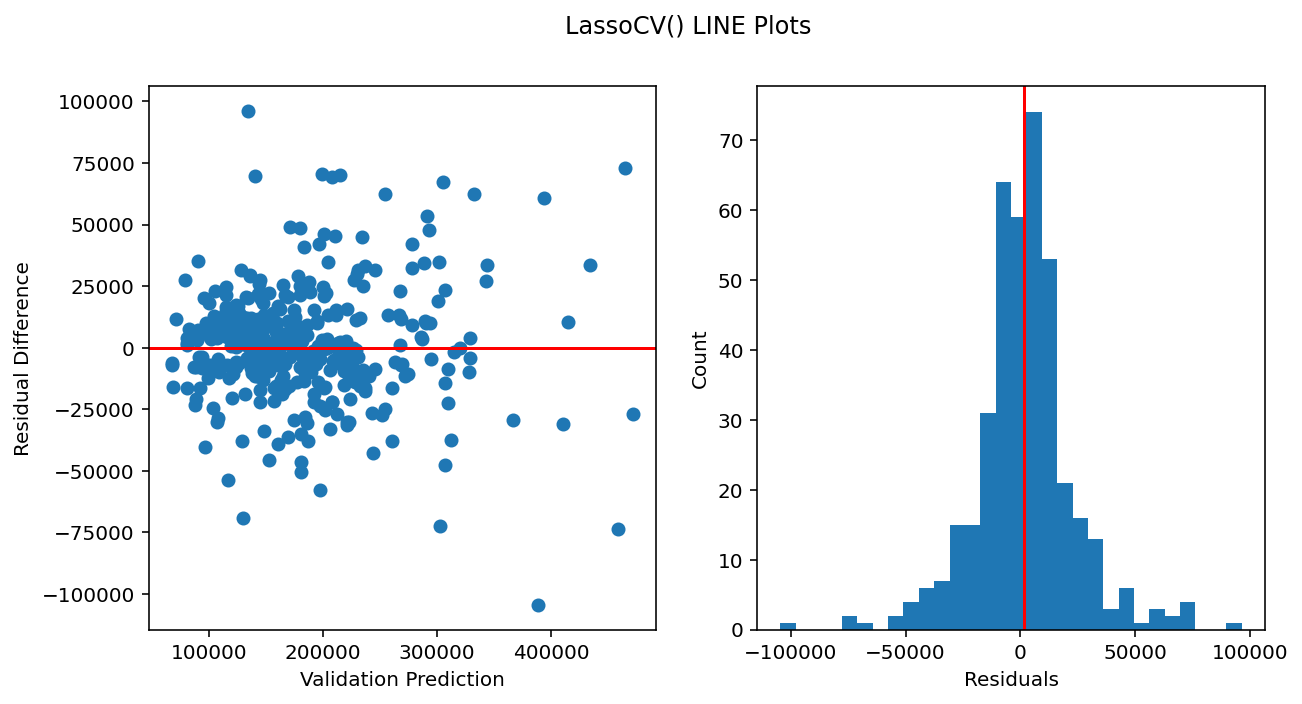

LassoCV() Training RMSE: 22477.65
LassoCV() Validation RMSE: 22419.2
LassoCV() RMSE Percent Variance: -0.26%

LassoCV() Training R2: 0.91
LassoCV() Validation R2: 0.9


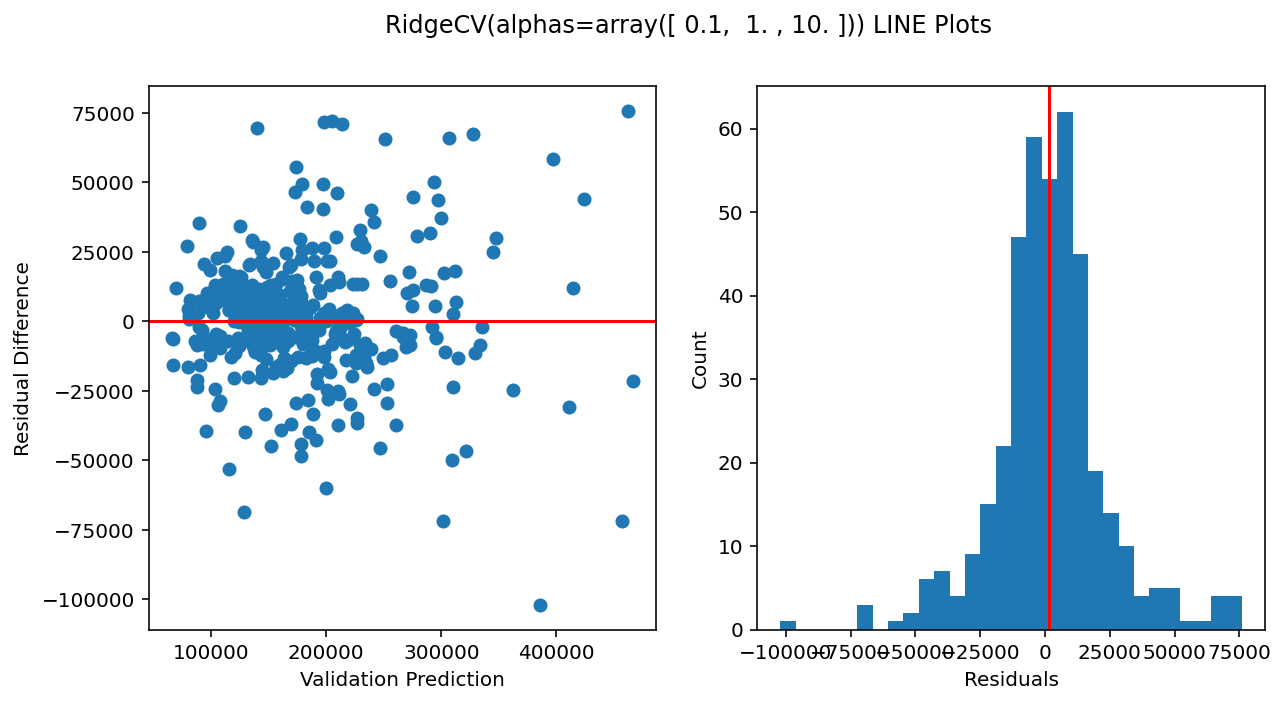

RidgeCV(alphas=array([ 0.1,  1. , 10. ])) Training RMSE: 22207.93
RidgeCV(alphas=array([ 0.1,  1. , 10. ])) Validation RMSE: 22176.82
RidgeCV(alphas=array([ 0.1,  1. , 10. ])) RMSE Percent Variance: -0.14%

RidgeCV(alphas=array([ 0.1,  1. , 10. ])) Training R2: 0.91
RidgeCV(alphas=array([ 0.1,  1. , 10. ])) Validation R2: 0.91


In [9]:
fit_pipe(LinearRegression())
fit_pipe(LassoCV())
fit_pipe(RidgeCV())

#### GridSearch

In [10]:
#adapted from class code extra-extras
ctx = ColumnTransformer(
    [('ss', StandardScaler(), X_train._get_numeric_data().columns),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'), [x for x in X_train.columns if x not in X_train._get_numeric_data().columns])
    ]
)

pipe = Pipeline([
    ('ctx', ctx),
    ('model', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp))
])

lasso_params = {
    'ctx__remainder' : ['passthrough'], # keep untransformed columns
    'model__regressor__alpha' : np.linspace(.001, 10, 100),
    'model__regressor__max_iter' : [10000]
}

ridge_params = {
    'ctx__remainder' : ['passthrough'], # keep untransformed columns
    'model__regressor__alpha' : np.linspace(1, 1000, num=100)
}

In [11]:
lasso_gs = GridSearchCV(pipe, 
                        lasso_params, 
                        scoring='neg_root_mean_squared_error').fit(X_train, y_train)

ridge_gs = GridSearchCV(pipe, ridge_params, scoring='neg_root_mean_squared_error').fit(X_train, y_train)


In [12]:
lasso_gs.best_params_, ridge_gs.best_params_

({'ctx__remainder': 'passthrough',
  'model__regressor__alpha': 7.071000000000001,
  'model__regressor__max_iter': 10000},
 {'ctx__remainder': 'passthrough',
  'model__regressor__alpha': 11.090909090909092})

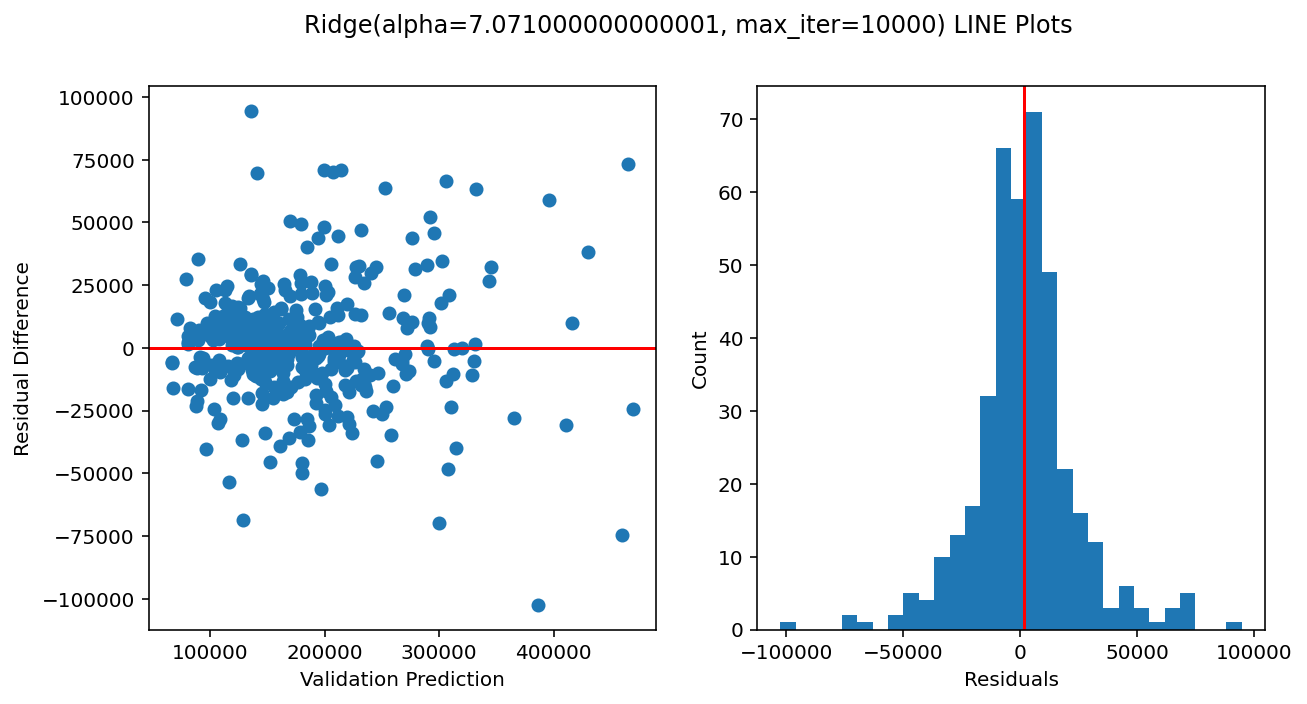

Ridge(alpha=7.071000000000001, max_iter=10000) Training RMSE: 22413.91
Ridge(alpha=7.071000000000001, max_iter=10000) Validation RMSE: 22345.57
Ridge(alpha=7.071000000000001, max_iter=10000) RMSE Percent Variance: -0.3%

Ridge(alpha=7.071000000000001, max_iter=10000) Training R2: 0.91
Ridge(alpha=7.071000000000001, max_iter=10000) Validation R2: 0.91


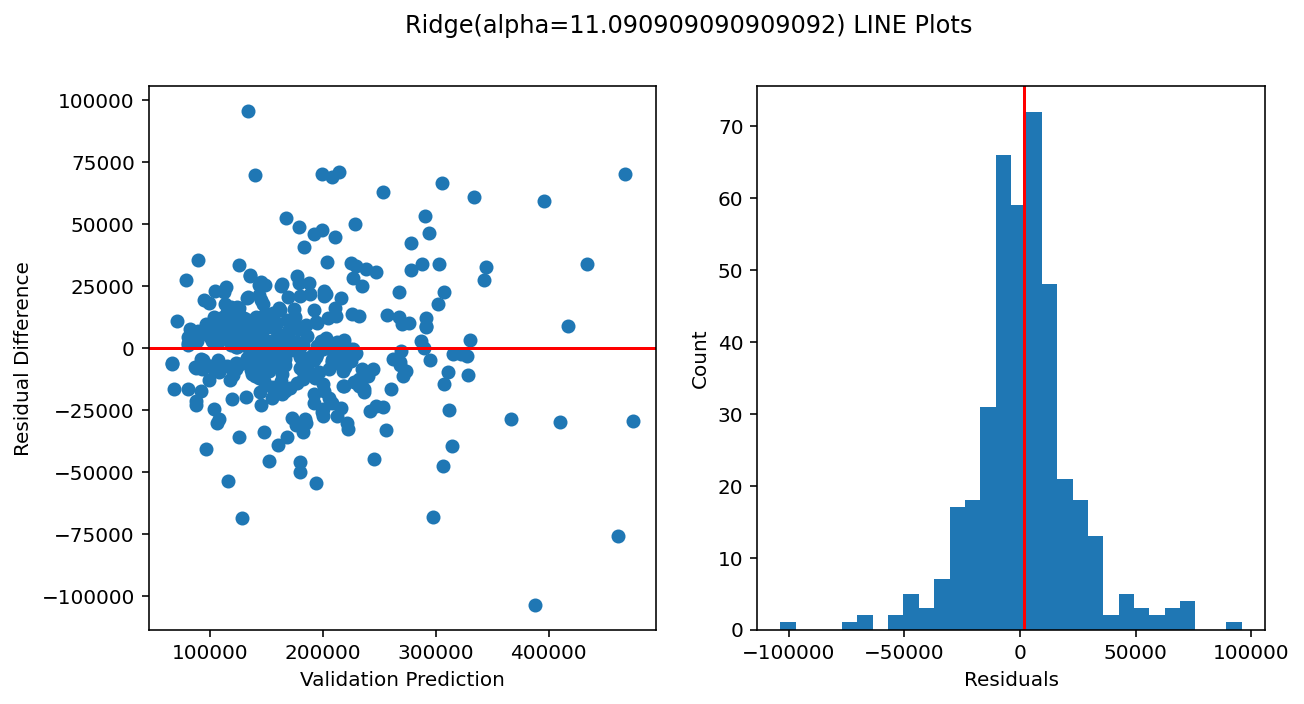

Ridge(alpha=11.090909090909092) Training RMSE: 22464.91
Ridge(alpha=11.090909090909092) Validation RMSE: 22320.45
Ridge(alpha=11.090909090909092) RMSE Percent Variance: -0.64%

Ridge(alpha=11.090909090909092) Training R2: 0.91
Ridge(alpha=11.090909090909092) Validation R2: 0.91


In [13]:
eval_pipe(lasso_gs.best_estimator_, lasso_gs.predict(X_train), lasso_gs.predict(X_val))
eval_pipe(ridge_gs.best_estimator_, ridge_gs.predict(X_train), ridge_gs.predict(X_val))

In [14]:
#see if any are 0'd out, none ever were
coefs = pd.DataFrame(data=[lasso_gs.best_estimator_.named_steps.ctx.get_feature_names_out(), lasso_gs.best_estimator_.named_steps.model.regressor_.coef_], index=['variable','coef']).T
coefs.sort_values(by='coef')

,variable,coef
27,ohe__neighborhood_IDOTRR,-0.090561
29,ohe__neighborhood_MeadowV,-0.070305
36,ohe__neighborhood_OldTown,-0.064032
18,ohe__neighborhood_BrDale,-0.063934
39,ohe__neighborhood_SawyerW,-0.049875
21,ohe__neighborhood_CollgCr,-0.042045
23,ohe__neighborhood_Edwards,-0.034454
37,ohe__neighborhood_SWISU,-0.024729
13,ohe__lot_config_FR2,-0.016308
40,ohe__neighborhood_Somerst,-0.014024


In [15]:
#save results
with open('../data/results.pickle', 'wb') as handle:
    pickle.dump(results, handle)

### Coefficient DataFrame
So I can inspect the coefficients and decide which ones to potentially drop.

In [16]:
sorted_results = sorted(results, key=lambda x: x[0])
print(f"Best Model: {sorted_results[0][2].named_steps.model.regressor} with variables\n\t{sorted_results[0][1]}")

coefs = pd.DataFrame(data=[sorted_results[0][2].named_steps.ctx.get_feature_names_out(), sorted_results[0][2].named_steps.model.regressor_.coef_], index=['variable','coef']).T
coefs.sort_values(by='coef')


Best Model: LinearRegression() with variables
	['overall_qual', 'total_overall_sf', 'garage_interact', 'years_interact', 'total_full_bath', 'sf_bath', 'fence_ord', 'bldg_type_ord', 'exter_qual_ord', 'bsmt_qual_ord', 'kitchen_qual_ord', 'lot_config', 'neighborhood']


,variable,coef
25,ohe__neighborhood_IDOTRR,-0.095
16,ohe__neighborhood_BrDale,-0.090467
27,ohe__neighborhood_MeadowV,-0.089222
34,ohe__neighborhood_OldTown,-0.059697
37,ohe__neighborhood_SawyerW,-0.03666
21,ohe__neighborhood_Edwards,-0.027064
35,ohe__neighborhood_SWISU,-0.023012
19,ohe__neighborhood_CollgCr,-0.022851
15,ohe__neighborhood_Blueste,-0.022083
26,ohe__neighborhood_Landmrk,-0.021382


These are the coefficients for my final model. It is interesting to note that neighborhoods were the strongest predictors on sale price for this model. These neighborhood affects are in comparison to if the house were in the Bloomington neighborhood. For example, if the house is in Green Hill, according to this model its sale price is going to be 77x higher than if it is in Bloomington. Through the data cleaning process, all data points in Bloomington were actually dropped, so I am going to avoid inference on these to my clients. Generally, coefficient inference is not the end goal of this model.

I did notice that of my two privacy columns, building type ordinal had a positive effect when predicting sale price, but privacy fence has a slight negative effect. This does not affect my final interpretaions of the models, but was interesting to note.

### Kaggle Submission

In [17]:
#read in cleaned test data
test = pd.read_csv("../data/cleaned_test.csv")
 
#sort best model to top
sorted_results = sorted(results, key=lambda x: x[0])

#make X_test using the appropriate columns for the model
X_test = test[sorted_results[0][1]]

#make predictions using the model
test_preds = sorted_results[0][2].predict(X_test)

#make a submission csv
pd.DataFrame(data={'Id': test['id'], 'SalePrice': test_preds}).to_csv('../submissions/lincoln-3.csv', index=False)
